# Logistics Regression Model Project

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

#### For the following questions, we will create a logistic regression classifier to determine the position of players: Backcourt (B) or Frontcourt (F). This will require us to clean, familiarize, and analyze the data through an end-to-end model building process.

##### - The NBA dataset originated from [this](https://www.basketball-reference.com/leagues/NBA_2020_per_game.html) basketball-reference page.
##### - Glossary for terms can be found [here](https://www.basketball-reference.com/about/glossary.html). (Note: This data file contains per game averages)
##### - **Edit:** Positions (Pos) has been simplified into two classifiers: [Frontcourt (F) and Backcourt (B)](https://www.rookieroad.com/basketball/the-court/front/).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file = '/content/drive/MyDrive/ML Course/Assignment 8/Players_2020.csv'

In [5]:
df = pd.read_csv(file)

In [6]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Steven Adams,F,26,OKC,63,63,26.7,4.5,7.6,...,0.582,3.3,6,9.3,2.3,0.8,1.1,1.5,1.9,10.9
1,2,Bam Adebayo,F,22,MIA,72,72,33.6,6.1,11,...,0.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
2,3,LaMarcus Aldridge,F,34,SAS,53,53,33.1,7.4,15,...,0.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
3,4,Kyle Alexander,F,23,MIA,2,0,6.5,0.5,1,...,NaN,1,0.5,1.5,0,0,0,0.5,0.5,1
4,5,Nickeil Alexander-Walker,B,21,NOP,47,1,12.6,2.1,5.7,...,0.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7


In [7]:
df.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rk      677 non-null    object
 1   Player  677 non-null    object
 2   Pos     677 non-null    object
 3   Age     677 non-null    object
 4   Tm      677 non-null    object
 5   G       677 non-null    object
 6   GS      677 non-null    object
 7   MP      677 non-null    object
 8   FG      677 non-null    object
 9   FGA     677 non-null    object
 10  FG%     675 non-null    object
 11  3P      677 non-null    object
 12  3PA     677 non-null    object
 13  3P%     642 non-null    object
 14  2P      677 non-null    object
 15  2PA     677 non-null    object
 16  2P%     671 non-null    object
 17  eFG%    675 non-null    object
 18  FT      677 non-null    object
 19  FTA     677 non-null    object
 20  FT%     644 non-null    object
 21  ORB     677 non-null    object
 22  DRB     677 non-null    ob

## 1. Data Exploration / Cleaning


##### Removing duplicate entries of players (some played for more than one team)

In [9]:
print(len(df['Player']))
print(df['Player'].value_counts())
df.drop_duplicates(subset ="Player", keep = 'first', inplace = True)
print('**BREAK**')
print(df['Player'].value_counts())
print(len(df))               #See that removing the duplicate entries worked 

677
Player                26
Jordan McRae           4
Anthony Tolliver       4
Glenn Robinson III     3
Jae Crowder            3
                      ..
Javonte Green          1
JaMychal Green         1
Draymond Green         1
Danny Green            1
Ivica Zubac            1
Name: Player, Length: 530, dtype: int64
**BREAK**
Steven Adams             1
E'Twaun Moore            1
Abdel Nader              1
Sviatoslav Mykhailiuk    1
Mike Muscala             1
                        ..
Rudy Gay                 1
Marc Gasol               1
Darius Garland           1
Langston Galloway        1
Ivica Zubac              1
Name: Player, Length: 530, dtype: int64
530


In [10]:
#Converting Pos to 0/1 so that I can see the correlation for this variable on the heatmap

df['Pos'] = pd.Series(np.where(df.Pos.values == 'F', 1, 0),
          df.index)

In [11]:
df['Pos']

0      1
1      1
2      1
3      1
4      0
      ..
672    0
673    1
674    1
675    1
676    1
Name: Pos, Length: 530, dtype: int64

##### Converting variables to appropriate data types

In [12]:
df[['Player', 'Tm']] = df[['Player', 'Tm']].astype(str)
df[['Rk', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']] = df[['Rk', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']].apply(pd.to_numeric, errors='coerce')

In [13]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,Steven Adams,1,26.0,OKC,63.0,63.0,26.7,4.5,7.6,...,0.582,3.3,6.0,9.3,2.3,0.8,1.1,1.5,1.9,10.9
1,2.0,Bam Adebayo,1,22.0,MIA,72.0,72.0,33.6,6.1,11.0,...,0.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
2,3.0,LaMarcus Aldridge,1,34.0,SAS,53.0,53.0,33.1,7.4,15.0,...,0.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
3,4.0,Kyle Alexander,1,23.0,MIA,2.0,0.0,6.5,0.5,1.0,...,NaN,1.0,0.5,1.5,0.0,0.0,0.0,0.5,0.5,1.0
4,5.0,Nickeil Alexander-Walker,0,21.0,NOP,47.0,1.0,12.6,2.1,5.7,...,0.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7


##### Plotting relationships between possible features and response variable.

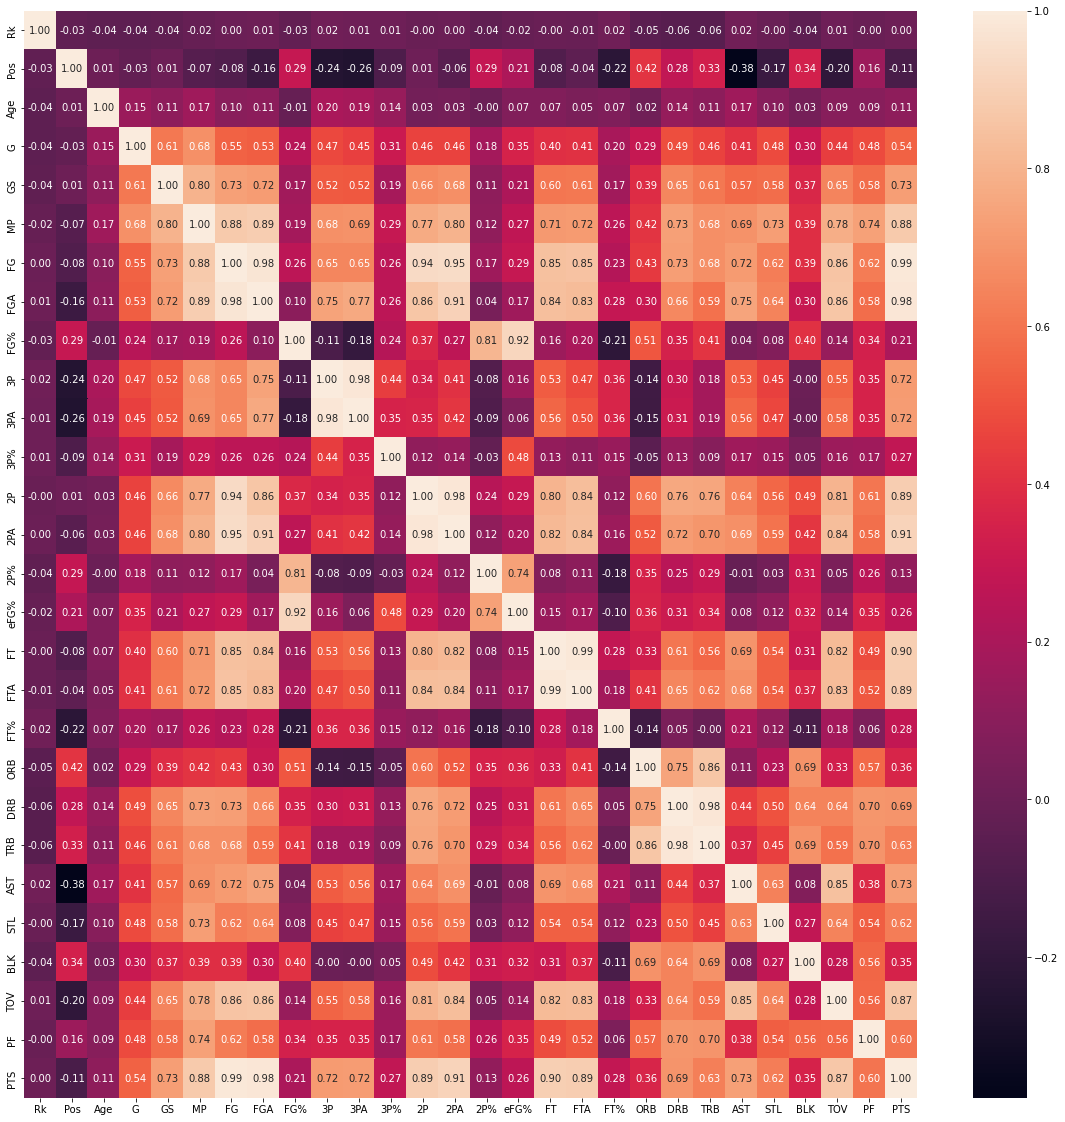

In [14]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(df.corr(), annot = True, fmt=".2f")                #easy to see heatmap of which indenpendent variables are correlated with others (including our target variable)

##### Top 5 variables are:

* ORB 
* AST
* BLK
* TRB
* 2P%



##### Dropping columns with weak correlations (under .1)

In [15]:
df.drop(['Rk', 'Age', 'G', 'GS', 'MP', '2P', '2PA', 'FTA', ], axis = 1)

,Player,Pos,Tm,FG,FGA,FG%,3P,3PA,3P%,2P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Steven Adams,1,OKC,4.5,7.6,0.592,0.0,0.0,0.333,0.594,...,0.582,3.3,6.0,9.3,2.3,0.8,1.1,1.5,1.9,10.9
1,Bam Adebayo,1,MIA,6.1,11.0,0.557,0.0,0.2,0.143,0.564,...,0.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
2,LaMarcus Aldridge,1,SAS,7.4,15.0,0.493,1.2,3.0,0.389,0.519,...,0.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
3,Kyle Alexander,1,MIA,0.5,1.0,0.500,0.0,0.0,NaN,0.500,...,NaN,1.0,0.5,1.5,0.0,0.0,0.0,0.5,0.5,1.0
4,Nickeil Alexander-Walker,0,NOP,2.1,5.7,0.368,1.0,2.8,0.346,0.391,...,0.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,Trae Young,0,ATL,9.1,20.8,0.437,3.4,9.5,0.361,0.501,...,0.860,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6
673,Cody Zeller,1,CHO,4.3,8.3,0.524,0.3,1.3,0.240,0.577,...,0.682,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1
674,Tyler Zeller,1,SAS,0.5,2.0,0.250,0.0,0.0,NaN,0.250,...,NaN,1.5,0.5,2.0,0.0,0.0,0.0,0.0,0.0,1.0
675,Ante Å½iÅ¾iÄ,1,CLE,1.9,3.3,0.569,0.0,0.0,NaN,0.569,...,0.737,0.8,2.2,3.0,0.3,0.3,0.2,0.5,1.2,4.4


##### Removing rows that are not player entries.

In [16]:
df = df[df.Player.apply(lambda x: x != 'Player')]

##### - Drop player entries with less than 30 games (G). (not enough data on these players).

In [17]:
# Games column dropped but here is how it could be done:

# df = df[df.G.apply(lambda x: x > 29)]

In [18]:
X_numerical = df[['ORB', 'AST', 'BLK', 'TRB', '2P%']]    #variables to use for the model
X_categorical = df[['Tm']]
Y = df[['Pos']]

##### Converting categorical variables to numerical variables (1s and 0s).

In [19]:
#Encoding the Team Column
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
X_categorical_encoded = onehotencoder.fit_transform(X_categorical).toarray()
X_categorical_encoded = pd.DataFrame(X_categorical_encoded)

###### Filling in empty entries.

In [20]:
Y.info()   #we can see here there are no null values for our Y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 0 to 676
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pos     529 non-null    int64
dtypes: int64(1)
memory usage: 8.3 KB


In [21]:
X_numerical.info()    #here there are 3 null values under 2P%. we will replace those with the mean of the column

mean_value=X_numerical['2P%'].mean()
  

X_numerical['2P%'].fillna(value=mean_value, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 0 to 676
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ORB     529 non-null    float64
 1   AST     529 non-null    float64
 2   BLK     529 non-null    float64
 3   TRB     529 non-null    float64
 4   2P%     526 non-null    float64
dtypes: float64(5)
memory usage: 24.8 KB


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [22]:
X_numerical.info()    #filled

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 0 to 676
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ORB     529 non-null    float64
 1   AST     529 non-null    float64
 2   BLK     529 non-null    float64
 3   TRB     529 non-null    float64
 4   2P%     529 non-null    float64
dtypes: float64(5)
memory usage: 24.8 KB


## 2. Splitting the data into three sets such that 60% will be the training data, 20% will be the validation data, and 20% will be the test data.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_numerical, Y, test_size = 0.4, random_state = 1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)

## 3. Selecting features of importance for predicting Position (Pos) and fitting models utilizing the `LogisticRegression()` function.


In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

scores = cross_val_score(rf, X_train, y_train.values.ravel(), cv=5)    #training features, training lables, 5 folds

In [33]:
scores

array([0.859375  , 0.828125  , 0.82539683, 0.82539683, 0.87301587])

In [39]:
def print_results(results):
  print('Best Params:  {}\n'.format(results.best_params_))

  means = results.cv_results_['mean_test_score']
  stds = results.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [40]:
parameters = {
    'n_estimators' : [5, 50, 100],
    'max_depth' : [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())
print_results(cv)

Best Params:  {'max_depth': 20, 'n_estimators': 100}

0.795 (+/-0.094) for {'max_depth': 2, 'n_estimators': 5}
0.83 (+/-0.049) for {'max_depth': 2, 'n_estimators': 50}
0.789 (+/-0.073) for {'max_depth': 2, 'n_estimators': 100}
0.823 (+/-0.094) for {'max_depth': 10, 'n_estimators': 5}
0.83 (+/-0.043) for {'max_depth': 10, 'n_estimators': 50}
0.839 (+/-0.038) for {'max_depth': 10, 'n_estimators': 100}
0.804 (+/-0.076) for {'max_depth': 20, 'n_estimators': 5}
0.842 (+/-0.028) for {'max_depth': 20, 'n_estimators': 50}
0.852 (+/-0.034) for {'max_depth': 20, 'n_estimators': 100}
0.785 (+/-0.078) for {'max_depth': None, 'n_estimators': 5}
0.836 (+/-0.034) for {'max_depth': None, 'n_estimators': 50}
0.83 (+/-0.038) for {'max_depth': None, 'n_estimators': 100}


## 4. Selecting a minimum of 3 models from question 4 and utilize the validation set to calculate the accuracy, precision, and recall of each model.

In [42]:
rf1 = RandomForestClassifier(n_estimators = 100, max_depth = 20)
rf1.fit(X_train, y_train.values.ravel())

rf2 = RandomForestClassifier(n_estimators = 50, max_depth = 20)
rf2.fit(X_train, y_train.values.ravel())

rf3 = RandomForestClassifier(n_estimators = 100, max_depth = 10)
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=10)

In [43]:
for model in [rf1, rf2, rf3]:
  y_pred = model.predict(X_val)
  accuracy = round(accuracy_score(y_val, y_pred), 3)
  precision = round(precision_score(y_val, y_pred), 3)
  recall = round(recall_score(y_val, y_pred), 3)
  print('Max Depth: {} / # of Est: {} -- A: {} / P: {} / R: {}'.format(model.max_depth, 
                                                                       model.n_estimators, 
                                                                       accuracy, 
                                                                       precision, 
                                                                       recall))

Max Depth: 20 / # of Est: 100 -- A: 0.783 / P: 0.766 / R: 0.86
Max Depth: 20 / # of Est: 50 -- A: 0.792 / P: 0.778 / R: 0.86
Max Depth: 10 / # of Est: 100 -- A: 0.774 / P: 0.754 / R: 0.86


## 5. Selecting the best model

In [ ]:
y_pred = rf2.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
print('Max Depth: {} / # of Est: {} -- A: {} / P: {} / R: {}'.format(rf2.max_depth, 
                                                                       rf2.n_estimators, 
                                                                       accuracy, 
                                                                       precision, 
                                                                       recall))